In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results_dir = Path("results")
results_err_dir = Path("results_error")
results_err_dir.mkdir(parents=True, exist_ok=True)

SYSTEM_SIZE = 16
TRAIN_SAMPLES = 20_000
ATOL_H = 1e-3

In [2]:
csv_path = results_dir / f"eval_results_L{SYSTEM_SIZE}_N{TRAIN_SAMPLES}.csv"
ref_path = Path(f"tfim_{SYSTEM_SIZE}_entangle_ref.csv")

df = pd.read_csv(csv_path)

needed = {"seed", "h", "l", "s2", "s2_err", "type"}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in {csv_path.name}: {sorted(missing)}")

df_sup = df[df["type"] == "support"].copy()

# canonical axes
h_support_vals = sorted(df_sup["h"].unique())
l_axis = sorted(df_sup["l"].unique())
seeds = sorted(df_sup["seed"].unique())

# ED reference (optional)
ref_df = pd.read_csv(ref_path) if ref_path.exists() else None

# dense arrays: (n_seeds, n_h, n_l)
S2 = np.full((len(seeds), len(h_support_vals), len(l_axis)), np.nan, dtype=float)
S2err = np.full_like(S2, np.nan)

seed_to_i = {s: i for i, s in enumerate(seeds)}
h_to_j = {h: j for j, h in enumerate(h_support_vals)}
l_to_k = {l: k for k, l in enumerate(l_axis)}

for row in df_sup.itertuples(index=False):
    i = seed_to_i[row.seed]
    j = h_to_j[row.h]
    k = l_to_k[row.l]
    S2[i, j, k] = float(row.s2)
    S2err[i, j, k] = float(row.s2_err)

print(f"Loaded: {csv_path.name}")
print(f"Details: {len(seeds)} seeds | {len(h_support_vals)} h-vals | {len(l_axis)} l-vals")

Loaded: eval_results_L16_N20000.csv
Details: 10 seeds | 7 h-vals | 8 l-vals


In [3]:
from matplotlib.lines import Line2D

def overlay_ed(ax):
    """Adds ED reference lines if available."""
    if ref_df is None:
        return None

    # Identify columns like 'l1', 'l2', etc.
    l_cols = sorted(
        [c for c in ref_df.columns if c.startswith("l") and c[1:].isdigit() and int(c[1:]) in l_axis],
        key=lambda s: int(s[1:])
    )
    if not l_cols:
        return None

    x_ref = np.array([int(c[1:]) for c in l_cols], dtype=int)

    # Plot reference lines
    plotted = False
    for h in h_support_vals:
        mask = np.isclose(ref_df["h"].to_numpy(), h, atol=ATOL_H)
        if mask.any():
            y_ref = ref_df.loc[mask].iloc[0][l_cols].to_numpy(dtype=float)
            ax.plot(x_ref, y_ref, "--", color="gray", linewidth=2, alpha=0.6, zorder=0)
            plotted = True

    if plotted:
        return Line2D([0], [0], color="gray", linestyle="--", linewidth=2, alpha=0.6, label="ED Reference")
    return None

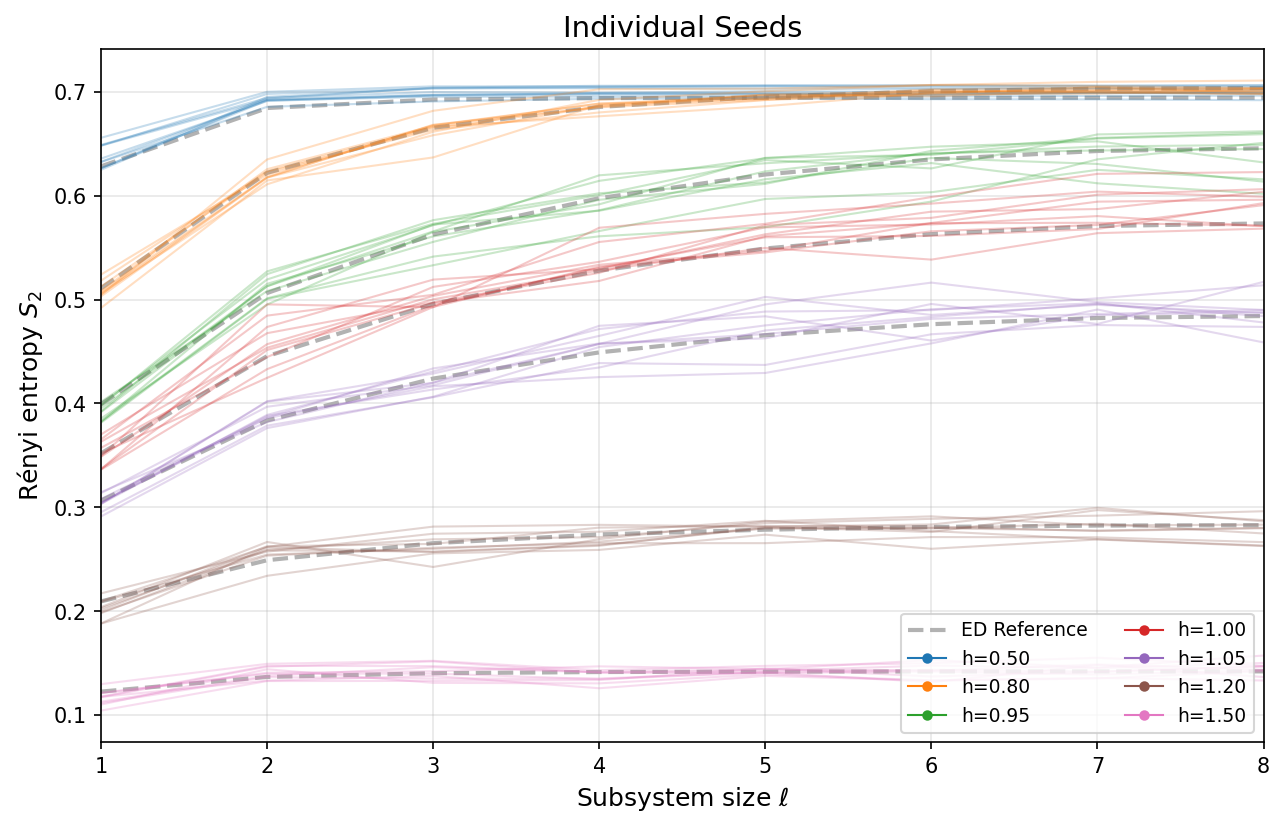

In [4]:
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
cmap = plt.get_cmap("tab10")

# 1. Add ED reference background
ed_handle = overlay_ed(ax)
handles = [ed_handle] if ed_handle else []

# 2. Plot individual seeds using LineCollection for performance
# Create a grid of x-values matching the shape of one seed's data
x_grid = np.tile(l_axis, (len(seeds), 1))

for j, h in enumerate(h_support_vals):
    color = cmap(j % 10)

    # Get all seeds for this h: shape (n_seeds, n_l)
    y_data = S2[:, j, :]

    # Combine x and y into segments: shape (n_seeds, n_l, 2)
    # This creates a list of lines [[(x1,y1), (x2,y2)...], ...]
    segments = np.stack((x_grid, y_data), axis=2)

    # Create one collection for all seeds of this h
    lc = LineCollection(segments, colors=[color], linewidths=1.0, alpha=0.25)
    ax.add_collection(lc)

    # Manual legend handle
    handles.append(
        Line2D([0], [0], color=color, marker="o", linestyle="-",
               linewidth=1.0, markersize=4, label=f"h={h:.2f}")
    )

ax.set_title("Individual Seeds", fontsize=14)
ax.set_xlabel(r"Subsystem size $\ell$", fontsize=12)
ax.set_ylabel(r"Rényi entropy $S_2$", fontsize=12)
ax.set_xlim(min(l_axis), max(l_axis))
# Auto-scale Y because add_collection doesn't do it automatically
ax.autoscale_view()
ax.grid(True, alpha=0.3)
ax.legend(handles=handles, loc="lower right", ncol=2, fontsize=9)

plt.show()

In [5]:
# Calculate median and std across seeds (axis 0)
S2_median = np.nanmedian(S2, axis=0)  # (n_h, n_l)
S2_std = np.nanstd(S2, axis=0)        # (n_h, n_l)

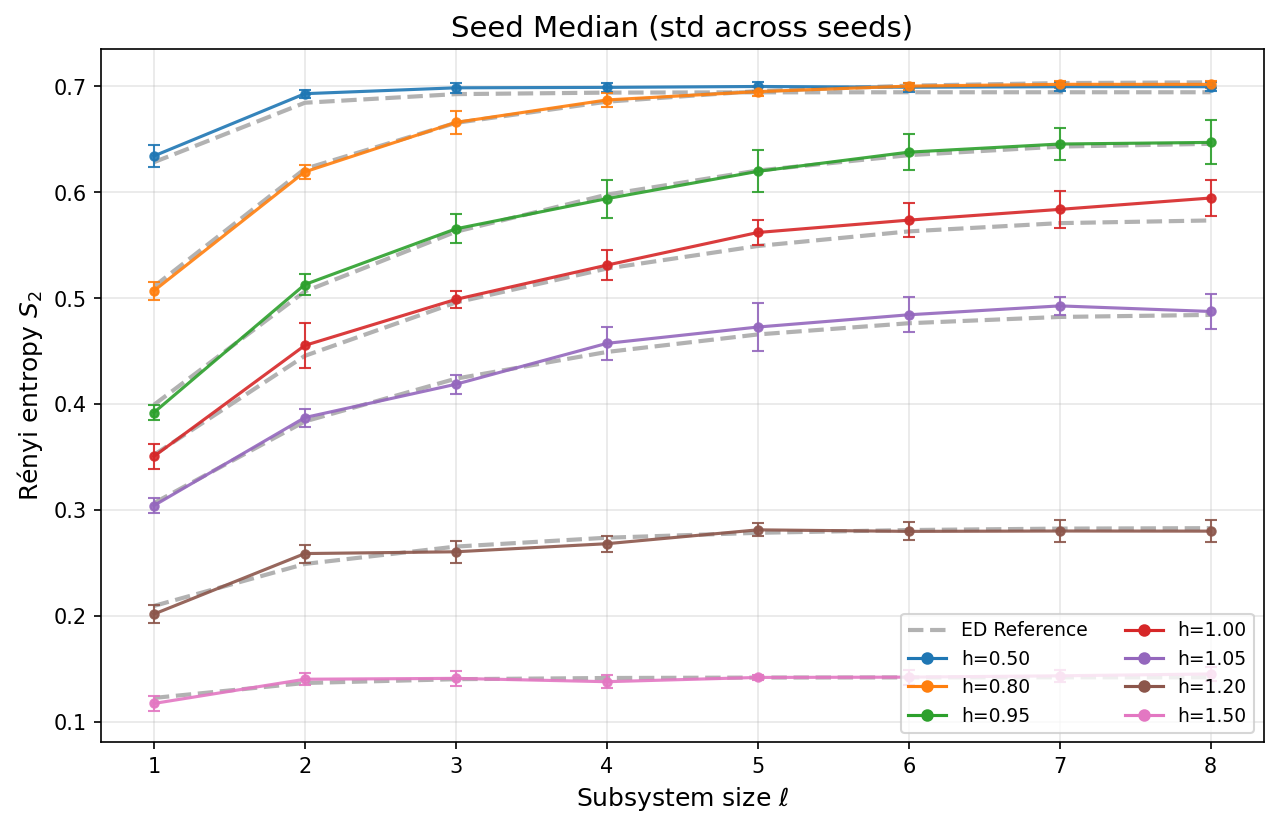

In [6]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
cmap = plt.get_cmap("tab10")

ed_handle = overlay_ed(ax)
handles = [ed_handle] if ed_handle else []

for j, h in enumerate(h_support_vals):
    color = cmap(j % 10)

    ax.errorbar(
        l_axis, S2_median[j], yerr=S2_std[j],
        fmt="o-", color=color, markersize=4, linewidth=1.5,
        elinewidth=1.0, capsize=3, alpha=0.9
    )

    handles.append(
        Line2D([0], [0], color=color, marker="o", linestyle="-",
               linewidth=1.5, markersize=5, label=f"h={h:.2f}")
    )

ax.set_title("Seed Median (std across seeds)", fontsize=14)
ax.set_xlabel(r"Subsystem size $\ell$", fontsize=12)
ax.set_ylabel(r"Rényi entropy $S_2$", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(handles=handles, loc="lower right", ncol=2, fontsize=9)

plt.show()

In [7]:
from datetime import datetime

# Save aggregated (median +/- std across seeds) for later plotting
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"tfim_{SYSTEM_SIZE}_entangle_rbm_err_{timestamp}.csv"
save_path = results_err_dir / filename

# Build tidy results table: one row per (h, l)
results_df = pd.DataFrame({
    "h": np.repeat(h_support_vals, len(l_axis)),
    "l": np.tile(l_axis, len(h_support_vals)),
    "s2": S2_median.reshape(-1),
    "s2_err": S2_std.reshape(-1),
    "type": "support",  # these are the support h-values by construction
})

results_df.to_csv(save_path, index=False)

print(f"Data saved to: {save_path}")
print(f"Rows: {len(results_df)}")

Data saved to: results_error/tfim_16_entangle_rbm_err_20260123_015209.csv
Rows: 56
